# Session 1

The [Global Uncertainty Reading Group Session 1](https://t.co/tnqU2tmiyU?amp=1) focused not on the contents of [The Statistical Consequences of Fat Tails](https://arxiv.org/abs/2001.10488) but instead on some basics of Extreme Value Theory.

We'll be performing the peaks over threshold (POT) method of analyzing tails.

1. Fetch the data and transform it such that our negative (left) tail is in the positive domain and representable by a Pareto.
1. Identify a value for `m` such that our tail begins after `m`. This is our threshold in POT.
1. Calibrate (fit) a Pareto distribution to the left tail of the return distribution.
1. Validate the effectiveness of our calibration via Posterior Predictive Check.
1. Examine the mean and variance of our calibrated distribution compared with our observed sample.

## TODO
Remaining work in order to make this notebook complete.

* Implement a method of selecting `m`, our threshold, using the PyMC model. I had difficulty updating `obs` on each iteration of the model. The fundamental issue is that `m` cannot generate a value lower than the lowest observation in `obs` otherwise we'll have `-Inf` log probability and the model will fail.

In [ ]:
import pandas as pd
import pymc as pm
import pytensor as pt
import seaborn as sns
import arviz as az
import scipy.stats as stats

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Technical-Incerto-Reading-Club/code-examples/main/Kickoff%20Session/boe_millenium_equity.csv")

In [ ]:
returns = (data['Index'] / data.shift(-12)['Index']).dropna() - 1.0

<Axes: xlabel='Index', ylabel='Count'>

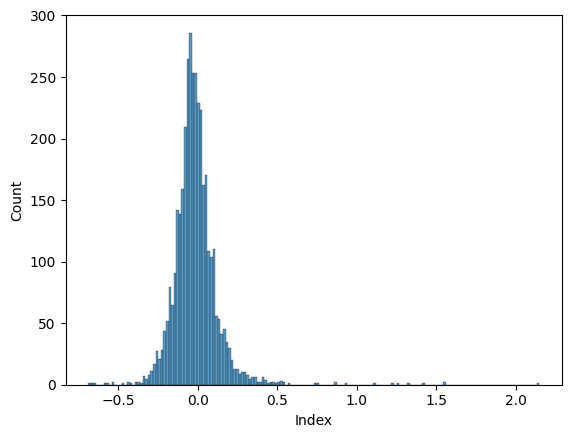

In [ ]:
sns.histplot(returns)

<Axes: xlabel='Index', ylabel='Count'>

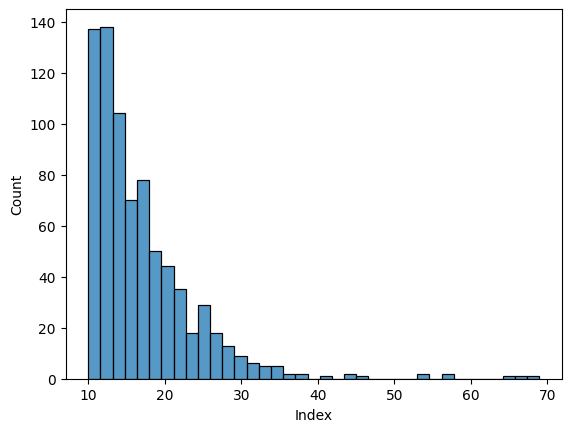

In [ ]:
left_data = (returns[returns < 0.0] * -1.0) * 100.0
left_data = left_data[left_data >= 10]
sns.histplot(left_data)

#test_data = pm.draw(pm.Pareto.dist(m=1, alpha=1.1), 100000)
#sns.histplot(test_data)

## Calibration
We can use PyMC to calibrate (fit) a Pareto distribution to our data by setting some priors on the parameters alpha and m, and then configuring a Pareto likelihood with our data set as the observations.

Output()

Output()

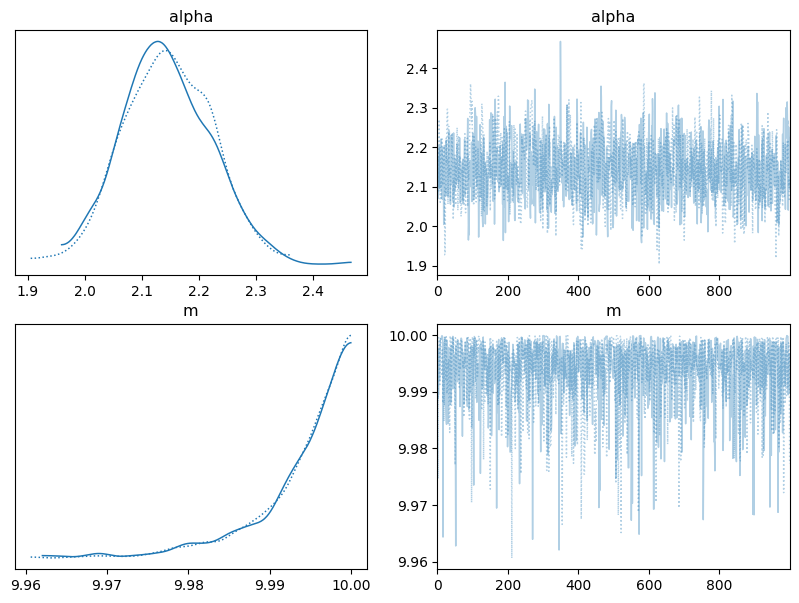

In [ ]:
obs = left_data
with pm.Model() as model:
  alpha = pm.Uniform('alpha', lower=0.001, upper=7.)
  m = pm.Uniform('m', lower=0, upper=obs.min()) # You cannot generate an m value for which obs has a lower observation

  likelihood = pm.Pareto('likelihood', m=m, alpha=alpha, observed=obs)
  idata = pm.sample()

  az.plot_trace(idata, figsize=(10, 7));

In [ ]:
idata.posterior['alpha'].values.mean(), idata.posterior['m'].values.mean()

NameError: name 'idata' is not defined

## Evaluation
The most straightforward method for evaluating our model is a posterior predictive check. Essentially we generate samples from our posterior and visually confirm they are indistinguishable from our observed data.

We also plot a [Bayesian P-Value](https://python.arviz.org/en/stable/api/generated/arviz.plot_bpv.html#arviz.plot_bpv) with `plot_bpv` in which we expect to see ~0.5. We see the average (dotted line) right at 0.5 but our posterior data (blue line) exceeds this. This may seem unexpected but if we've estimated the true distribution it is almost certainly higher than our observed samples as noted in the Technical Incerto!

Output()

<Axes: title={'center': 'likelihood'}>

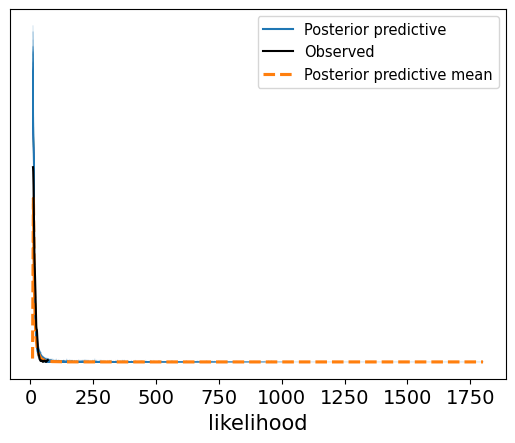

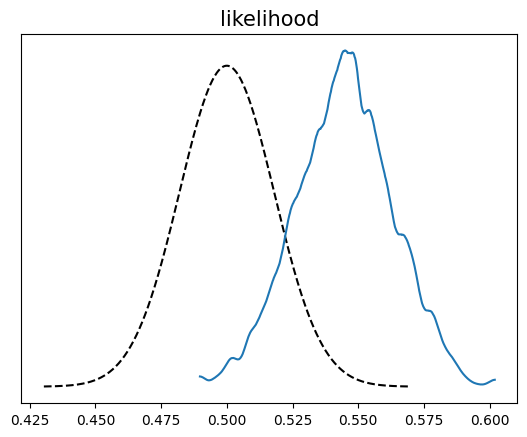

In [ ]:
  pm.sample_posterior_predictive(idata, extend_inferencedata=True, model=model)
  az.plot_ppc(idata, num_pp_samples=100);
  az.plot_bpv(idata, kind="p_value")

For my own interest I'd prefer if the underlying computer algebra system (CAS) could inform me about the distribution inferred. I found a `distributions.moments` namespace in PyMC installed from the github repo (unreleased as of now) that contained a `mean` function. I copied the implementation and wrote the variance function based on [Wikipedia's Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution) entry.

In [ ]:
from functools import singledispatch
from pytensor.tensor.variable import TensorVariable
from pytensor.tensor.random.basic import ParetoRV
from pymc.distributions.moments.means import maybe_resize
import numpy as np

def variance(rv: TensorVariable) -> TensorVariable:
  """Compute the variance of a random variable.

  The only parameter to this function is the RandomVariable
  for which the value is to be derived.
  """
  return _variance(rv.owner.op, rv, *rv.owner.inputs)

@singledispatch
def _variance(op, rv, *rv_inputs) -> TensorVariable:
  raise NotImplementedError(f"Variable {rv} of type {op} has no mean implementation.")

@_variance.register(ParetoRV)
def pareto_variance(op, rv, rng, size, alpha, m):
  return maybe_resize(pt.tensor.switch(alpha > 2, ((m**2)*alpha)/(((alpha-1)**2)*(alpha-2)), np.inf), size)

## Point Estimates
We generally prefer to push as much of our computation as possible into PyMC. However we're operating on a sample in PyMC and we know samples tend to underestimate moments on thick tailed distributions. Let's construct a Pareto with our calibrated parameters and then extract the first and second moments.

In [ ]:
#from pymc.distributions.moments.means import mean
dist = pm.Pareto.dist(alpha=idata.posterior['alpha'].values.mean(), m=idata.posterior['m'].values.mean())
#print(mean(dist).eval())
print(variance(dist).eval())

1134.269439009663


In [ ]:
np.exp(pm.logp(dist, np.arange(10, 1000, 1)).eval()) // Graph me?

array([2.14131781e-01, 1.58684264e-01, 1.20703182e-01, 9.38467806e-02,
       7.43402466e-02, 5.98429992e-02, 4.88523182e-02, 4.03739724e-02,
       3.37326872e-02, 2.84591194e-02, 2.42203163e-02, 2.07757264e-02,
       1.79486812e-02, 1.56074910e-02, 1.36526639e-02, 1.20081041e-02,
       1.06149526e-02, 9.42720953e-03, 8.40858033e-03, 7.53017436e-03,
       6.76880544e-03, 6.10572317e-03, 5.52565616e-03, 5.01608358e-03,
       4.56667560e-03, 4.16886000e-03, 3.81548384e-03, 3.50054746e-03,
       3.21899379e-03, 2.96654049e-03, 2.73954533e-03, 2.53489756e-03,
       2.34992985e-03, 2.18234649e-03, 2.03016447e-03, 1.89166510e-03,
       1.76535387e-03, 1.64992718e-03, 1.54424455e-03, 1.44730539e-03,
       1.35822939e-03, 1.27624009e-03, 1.20065087e-03, 1.13085308e-03,
       1.06630597e-03, 1.00652799e-03, 9.51089436e-04, 8.99606033e-04,
       8.51733468e-04, 8.07162628e-04, 7.65615490e-04, 7.26841538e-04,
       6.90614655e-04, 6.56730399e-04, 6.25003626e-04, 5.95266405e-04,
      

In [ ]:
obs.std()**2

52.835787207692086

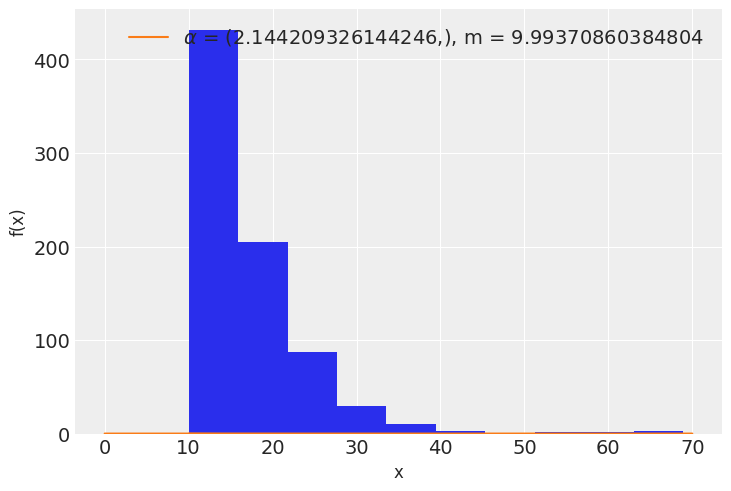

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('arviz-darkgrid')
x = np.linspace(0, 70, 1000)
alphas = [1., 2., 5., 5.]
ms = [1., 1., 1., 2.]
plt.hist(obs)
alpha=idata.posterior['alpha'].values.mean(),
m=idata.posterior['m'].values.mean()
pdf = st.pareto.pdf(x, alpha, scale=m)
plt.plot(x, pdf, label=r'$\alpha$ = {}, m = {}'.format(alpha, m))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [ ]:
stats.pareto(10)